In [1]:
import pandas as pd
import numpy as np
import string
import json
from IPython.display import display
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from  datetime import datetime
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import scipy.misc
from pathlib import Path
from urlpath import URL
import os
from copy import deepcopy
import mxnet as mx
import cv2
import cv2 as cv
import numpy as np
from gluoncv.data import ImageNet1kAttr
from gluoncv.data.transforms.presets.imagenet import transform_eval
from mxnet import nd
import face_recognition
from facial_emotion_recognition import EmotionRecognition
import torch
from facenet_pytorch import MTCNN
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gluoncv import model_zoo, data, utils

from matplotlib.pyplot import imshow,subplots
%matplotlib inline

pd.options.display.max_columns = None
# Use 'display(df)' instead of 'df' to display all columns.

In [2]:
PATH = "data/thumbnailsHQ/"


In [3]:
def readJSONList(path):
    with open(path, 'r') as file:
        loaded_list = json.loads(file.read())
    return loaded_list

def writeJSONList(path, list_to_save):
    with open(path, 'w') as file:
        file.write(json.dumps(list_to_save))

def downloadThumbnails(df, quality='hq'):
    list_of_ids_without_thumbnail = []
    ids = df["video_id"].values
    urls = df["thumbnail_link"].values
    
    region = df['region'][0]
    Path("./thumbnailsHQ/" + region).mkdir(parents=True, exist_ok=True)
    savepath = Path("./thumbnailsHQ/" + region)
    filename = quality + 'default.jpg'
    
    for id, url in zip(ids, urls): 
        temp_url = URL(url)
        temp_url = temp_url.parent / filename
        
        try:
            img = io.imread(str(temp_url))
        except Exception:
            list_of_ids_without_thumbnail.append(id)
            print(f"{id} no thumbnail")
            continue
        io.imsave(savepath / (id + ".png") , img)
    
    writeJSONList(savepath / "ids_without_thumbnail.txt", list_of_ids_without_thumbnail)
        
    return list_of_ids_without_thumbnail

In [23]:
# downloadThumbnails(dfUS)



def load_files(df,list_of_files):
    images = []
    images_raw = []
    ids = []
    path="data/thumbnailsHQ/"+str(df['region'][0])+"/"
    for index, row in df.iterrows():
        if (""+row['video_id']+".png") in list_of_files:
            img_path = path+row['video_id']+".png"
            img = image.load_img(img_path, target_size=(299, 299))
            x = image.img_to_array(img)
            images.append(x)
            ids.append(row['video_id'])
            images_raw.append(img)          
        else:
            pass    
    images_np = np.array(deepcopy(images))
    print(images_np.shape)
    return images_np, ids,images_raw


def load_filescv(df,list_of_files):
    images = []
    images_raw = []
    ids = []
    path="data/thumbnailsHQ/"+str(df['region'][0])+"/"
    for index, row in df.iterrows():
        if (""+row['video_id']+".png") in list_of_files:
            img_path = path+row['video_id']+".png"
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            x = image.img_to_array(img)
            images.append(x)
            ids.append(row['video_id'])
            images_raw.append(img)       
        else:
            pass
    
    images_np = np.array(deepcopy(images))
    print(images_np.shape)
    return images_np, ids,images_raw


def load_filesfr(df,list_of_files):
    images = []
    images_raw = []
    ids = []
    path="data/thumbnailsHQ/"+str(df['region'][0])+"/"
    for index, row in df.iterrows():
        if (""+row['video_id']+".png") in list_of_files:
            img_path = path+row['video_id']+".png"
            img = face_recognition.load_image_file(img_path)
            x = image.img_to_array(img)
            images.append(x)
            ids.append(row['video_id'])
            images_raw.append(img)       
        else:
            pass
    
    images_np = np.array(deepcopy(images))
    print(images_np.shape)
    return images_np, ids,images_raw

def get_predictionsYolo(df,list_of_files):
    images,ids,images_raw = load_files(df,list_of_files)
    net = model_zoo.get_model('yolo3_darknet53_coco',pretrained=True)
    narray = mx.ndarray.array(images)
    labels_all = []
    for img in narray:
        x, img = data.transforms.presets.yolo.transform_test(img, short=512)
        class_IDs, scores, bounding_boxs = net(x)
        ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0],
                                 class_IDs[0], class_names=net.classes)
        plt.show()
        labels_img = []
        labels= np.array(net.classes)
        nids = class_IDs.asnumpy()
        nscores = scores.asnumpy()
        length = len(class_IDs[0])
#         print(length)
        for l in range(length):
            if nids.item(l) != -1:
                labels_img.append([labels[int(nids.item(l))],nscores.item(l)])
            else:
                break

        labels_all.append(labels_img)
        

    return list(zip(labels_all,ids))

def get_predictionsRESNET(df,list_of_files):
    images,ids,images_raw = load_files(df,list_of_files)
    net = model_zoo.get_model('resnet152_v1b',pretrained=True)
    narray = mx.ndarray.array(images)
    labels_all = []
    classes = net.classes
    for img in narray:
        x = transform_eval(img)
        pred = net(x)
        plt.imshow(images_raw[0])
        plt.show()
        labels_img = []
        topK = 5
        ind = nd.topk(pred, k=topK)[0].astype('int')
        for i in range(topK):
            labels_img.append([classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()])
        labels_all.append(labels_img)
    return list(zip(labels_all,ids))
    
def get_predictionsImagenet(df,list_of_files):
    images,ids,images_raw = load_files(df,list_of_files) 
    model = Xception(weights='imagenet')
    preds = model.predict(images)
    return decode_predictions(preds, top=3)

# def faceRecognition(df, list_of_files):    
#     images,ids,images_raw = load_filesfr(df,list_of_files)
#     for img in images_raw: 
# #         print(img)
#         face_locations = face_recognition.face_locations(img)
#         print(face_locations)
#         print("NEXT")
#     return 0

def emotionRecognition(df, list_of_files):
    er = EmotionRecognition(device='gpu', gpu_id=0)
    
    mtcnn =  MTCNN(keep_all=True, device=torch.device(f'cuda:0'))
    emotions_all = []
    
    images,ids,images_raw = load_filescv(df,list_of_files)
    print(len(images_raw))
    for frame in images_raw:
        emotions_image = []
        f_h, f_w, c = frame.shape
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        boxes, _ = mtcnn.detect(frame)
        if boxes is not None:
            for i in range(len(boxes)):
                x1, y1, x2, y2 = int(round(boxes[i][0])), int(round(boxes[i][1])), int(round(boxes[i][2])), int(
                    round(boxes[i][3]))
                emotion = er._predict(gray[y1:y2, x1:x2])
                emotions_image.append(emotion)
                frame = cv.rectangle(frame, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=1)
                frame = cv.rectangle(frame, (x1, y1 - int(f_h*0.03125)), (x1 + int(f_w*0.125), y1), color=[0, 255, 0], thickness=-1)
                frame = cv.putText(frame, text=emotion, org=(x1 + 5, y1 - 3), fontFace=cv.FONT_HERSHEY_PLAIN,
                                   color=[0, 0, 0], fontScale=1, thickness=1)

            plt.imshow(frame)
            plt.show()
        else:
            plt.imshow(frame)
            plt.show()
        emotions_all.append(emotions_image)
    return list(zip(emotions_all,ids))
#         emotion = er._predict(img)
#         plt.imshow(frame)
#         plt.show()
#         print(face_locations)
#         print("NEXT")

# images_np,ids,images_raw = load_files()
# predictions = get_predictions(images_np)
# preds = faceRecognition(df,list_of_files)
# emotions_all = emotionRecognition(df,list_of_files)
# yolo_pred = get_predictionsYolo(df,list_of_files)
# print(preds)

# Przyklad wykrywania twarzy(MTCNN) i emocji  (Rayyan-Akhtar Facial_Emotion_Recognition) [github](https://github.com/Rayyan-Akhtar/Facial_Emotion_Recognition/tree/1ed5638bde6780cb85adeab770f7589d35c1057a)

[*] Accuracy: 0.9565809379727686
(2, 360, 480, 3)
2


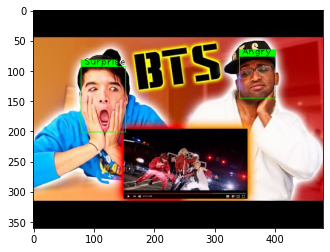

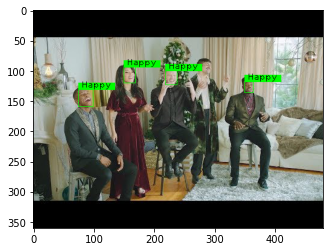

In [18]:
dfGB = pd.read_csv("./GB_new_columns.csv",skiprows=range(1,503), nrows=2)
# dfUS = pd.read_csv("./US_new_columns.csv")
list_of_filesGB = []
path="data/thumbnailsHQ/GB/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesGB.append(os.path.join(file))
list_of_filesUS = []
        
emotions_all = emotionRecognition(dfGB,list_of_filesGB)  


# Przyklad wykrywania obiektów za pomocą yolo

(5, 299, 299, 3)


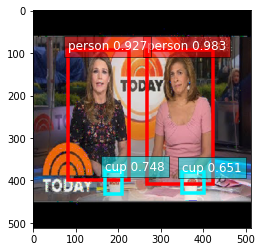

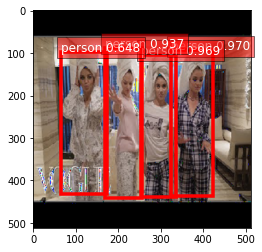

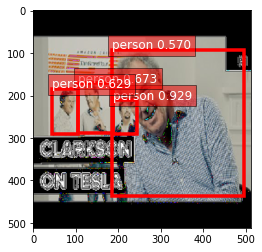

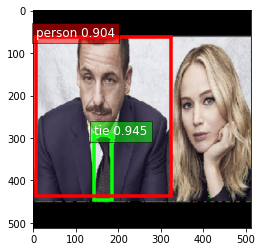

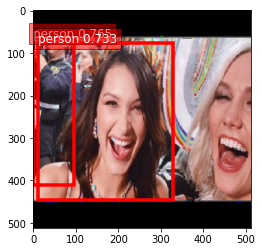

In [26]:
dfGB = pd.read_csv("./GB_new_columns.csv",skiprows=range(1,534), nrows=5)
# dfUS = pd.read_csv("./US_new_columns.csv")
list_of_filesGB = []
path="data/thumbnailsHQ/GB/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesGB.append(os.path.join(file))
list_of_filesUS = []
        
emotions_all = get_predictionsYolo(dfGB,list_of_filesGB)  


# Przyklad klasyfikacji obrazów za pomoca resnet152_v1b

(1, 299, 299, 3)


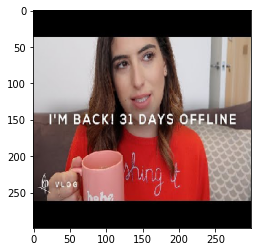

[([['academic gown', 0.13001302],
   ["potter's wheel", 0.10224282],
   ['web site', 0.08589978],
   ['coffee mug', 0.049148407],
   ['wig', 0.02830019]],
  'tSjvx_c4meE')]

In [28]:
dfGB = pd.read_csv("./GB_new_columns.csv",skiprows=range(1,123), nrows=1)
# dfUS = pd.read_csv("./US_new_columns.csv")
list_of_filesGB = []
path="data/thumbnailsHQ/GB/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesGB.append(os.path.join(file))
list_of_filesUS = []
        
get_predictionsRESNET(dfGB,list_of_filesGB)  



# Generowanie danych

In [ ]:
# dfGB = pd.read_csv("./GB_new_columns.csv")
# dfUS = pd.read_csv("./US_new_columns.csv")

list_of_filesGB = []
path="data/thumbnailsHQ/GB/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesGB.append(os.path.join(file))
list_of_filesUS = []
path="data/thumbnailsHQ/US/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesUS.append(os.path.join(file))

# for i in range(7):
#     dfGB = pd.DataFrame()
#     if i > 0:
#         dfGB = pd.read_csv("./GB_new_columns.csv",skiprows=range(1,i*500), nrows=500)
#     else:
#         dfGB = pd.read_csv("./GB_new_columns.csv", skiprows=i*500, nrows=500)
    
#     print(dfGB.shape)
#     print(dfGB.columns)

#     print("I:"+str(i)+ " size: "+str(len(dfGB)))
#     print("EMOTIONS")
#     predsEmotionsGB = emotionRecognition(dfGB,list_of_filesGB)
#     df_predsEmotionsGB = pd.DataFrame(predsEmotionsGB)
#     df_predsEmotionsGB.to_csv("data/out/dfGB_predsEmotions{0}.csv".format(i))
#     print("RESNET")

#     predsYOLOGB = get_predictionsYolo(dfGB,list_of_filesGB)
#     df_predsYOLOGB = pd.DataFrame(predsYOLOGB)
#     df_predsYOLOGB.to_csv("data/out/dfGB_predsYOLO{0}.csv".format(i))
#     print("YOLO")
#     predsResNetGB = get_predictionsRESNET(dfGB,list_of_filesGB)
#     df_predsResNetGB = pd.DataFrame(predsResNetGB)
#     df_predsResNetGB.to_csv("data/out/dfGB_predsResNet{0}.csv".format(i))



# for i in range(13):
#     dfUS = pd.DataFrame()
#     if i > 0:
#         dfUS = pd.read_csv("./US_new_columns.csv",skiprows=range(1,i*500), nrows=500)
#     else:
#         dfUS = pd.read_csv("./US_new_columns.csv",skiprows=i*500, nrows=500)
#     print("I:"+str(i)+ " size: "+str(len(dfUS)))
#     print("EMOTIONS")
#     predsEmotionsUS = emotionRecognition(dfUS,list_of_filesUS)
#     df_predsEmotionsUS = pd.DataFrame(predsEmotionsUS)
#     df_predsEmotionsUS.to_csv("data/out/dfUS_predsEmotions{0}.csv".format(i))
#     print("RESNET")
#     predsResNetUS = get_predictionsRESNET(dfUS,list_of_filesUS)
#     df_predsResNetUS = pd.DataFrame(predsResNetUS)
#     df_predsResNetUS.to_csv("data/out/dfUS_predsResNet{0}.csv".format(i))
#     print("YOLO")
#     predsYOLOUS = get_predictionsYolo(dfUS,list_of_filesUS)
#     df_predsYOLOUS = pd.DataFrame(predsYOLOUS)
#     df_predsYOLOUS.to_csv("data/out/dfUS_predsYOLO{0}.csv".format(i))

# Scalanie danych

In [29]:
dfGB_all = pd.read_csv("./GB_new_columns.csv")
dfUS_all = pd.read_csv("./US_new_columns.csv")

# GB
leGb = 7
emotionGB = "data/out/dfGB_predsEmotions{0}.csv"
resGb = "data/out/dfGB_predsResNet{0}.csv"
yoloGb = "data/out/dfGB_predsYOLO{0}.csv"

dfemotionGB = pd.DataFrame()
dfresGb = pd.DataFrame()
dfyoloGb = pd.DataFrame()
temp_emotions = []
temp_res = []
temp_yolo = []
for i in range(leGb):
    temp_emotions.append(pd.read_csv(emotionGB.format(i)))
    temp_res.append(pd.read_csv(resGb.format(i)))
    temp_yolo.append(pd.read_csv(yoloGb.format(i)))
    
# print(len(temp_emotions))
temp_emotionsDf = pd.concat(temp_emotions, sort=False)
temp_emotionsDf.columns = ['0','emotions','id']
temp_emotionsDf = temp_emotionsDf.drop('0', axis = 1)

temp_resDF = pd.concat(temp_res, sort=False)
temp_resDF.columns = ['0','categories','id']
temp_resDF = temp_resDF.drop('0', axis = 1)

temp_yoloDF = pd.concat(temp_yolo, sort=False)
temp_yoloDF.columns = ['0','objects','id']
temp_yoloDF = temp_yoloDF.drop('0', axis = 1)
# dfGBnew  = pd.

dfGb = temp_emotionsDf
dfGb = temp_emotionsDf.merge(temp_resDF, left_on='id', right_on='id')
dfGb = dfGb.merge(temp_yoloDF, left_on='id', right_on='id')


# USA
leUS = 13
emotionUS = "data/out/dfUS_predsEmotions{0}.csv"
resUS = "data/out/dfUS_predsResNet{0}.csv"
yoloUS = "data/out/dfUS_predsYOLO{0}.csv"

dfemotionUS = pd.DataFrame()
dfresUS = pd.DataFrame()
dfyoloUS = pd.DataFrame()
temp_emotions = []
temp_res = []
temp_yolo = []
for i in range(leUS):
    temp_emotions.append(pd.read_csv(emotionUS.format(i)))
    temp_res.append(pd.read_csv(resUS.format(i)))
    temp_yolo.append(pd.read_csv(yoloUS.format(i)))

# print(len(temp_emotions))
temp_emotionsDf = pd.concat(temp_emotions, sort=False)
temp_emotionsDf.columns = ['0','emotions','id']
temp_emotionsDf = temp_emotionsDf.drop('0', axis = 1)

temp_resDF = pd.concat(temp_res, sort=False)
temp_resDF.columns = ['0','categories','id']
temp_resDF = temp_resDF.drop('0', axis = 1)

temp_yoloDF = pd.concat(temp_yolo, sort=False)
temp_yoloDF.columns = ['0','objects','id']
temp_yoloDF = temp_yoloDF.drop('0', axis = 1)
# dfGBnew  = pd.

dfUS = temp_emotionsDf
dfUS = temp_emotionsDf.merge(temp_resDF, left_on='id', right_on='id')
dfUS = dfUS.merge(temp_yoloDF, left_on='id', right_on='id')




# Generowanie kolumn dla US

In [ ]:
dfUS['Sad'] = [x.count("Sad") for x in dfUS['emotions']]
dfUS['Fear'] = [x.count("Fear") for x in dfUS['emotions']]
dfUS['Angry'] = [x.count("Angry") for x in dfUS['emotions']]
dfUS['Happy'] = [x.count("Happy") for x in dfUS['emotions']]
dfUS['Neutral'] = [x.count("Neutral") for x in dfUS['emotions']]
dfUS['Surprise'] = [x.count("Surprise") for x in dfUS['emotions']]


dfUS['categories_list'] = [[y.replace("'", '') for y in re.findall("'[a-z ]+'", x)] for x in dfUS['categories']]
dfUS['object_list'] = [[y.replace("'", '') for y in re.findall("'[a-z ]+'", x)] for x in dfUS['objects']]
dfUS['people'] = [x.count('person') for x in dfUS['object_list']]
# print(dfUS.columns)

for index,row in dfUS.iterrows():
    dfUS.loc[index,'faces'] = row['Sad']+row['Fear']+row['Angry']+row['Happy']+row['Neutral']+row['Surprise']
# dfUS

# Generowanie kolumn dla GB

In [31]:
dfGb['Sad'] = [x.count("Sad") for x in dfGb['emotions']]
dfGb['Fear'] = [x.count("Fear") for x in dfGb['emotions']]
dfGb['Angry'] = [x.count("Angry") for x in dfGb['emotions']]
dfGb['Happy'] = [x.count("Happy") for x in dfGb['emotions']]
dfGb['Neutral'] = [x.count("Neutral") for x in dfGb['emotions']]
dfGb['Surprise'] = [x.count("Surprise") for x in dfGb['emotions']]


dfGb['categories_list'] = [[y.replace("'", '') for y in re.findall("'[a-z ]+'", x)] for x in dfGb['categories']]
dfGb['object_list'] = [[y.replace("'", '') for y in re.findall("'[a-z ]+'", x)] for x in dfGb['objects']]
dfGb['people'] = [x.count('person') for x in dfGb['object_list']]
# print(dfGb.columns)

for index,row in dfGb.iterrows():
    dfGb.loc[index,'faces'] = row['Sad']+row['Fear']+row['Angry']+row['Happy']+row['Neutral']+row['Surprise']
# dfGb

In [40]:
dfGb

emotions           id  \
0                   ['Happy', 'Angry', 'Angry', 'Fear']  n1WpP7iowLc   
1     ['Neutral', 'Angry', 'Angry', 'Angry', 'Sad', ...  PUTEiSjKwJU   
2                                             ['Happy']  AumaWl0TNBo   
3                                                    []  2Vv-BfVoq4g   
4                                                    []  LMCuKltaY3M   
...                                                 ...          ...   
2850                                            ['Sad']  YQJmvXamKYg   
2851                                 ['Sad', 'Neutral']  i63jWjoAWHE   
2852                                          ['Happy']  V15BYnSr0P8   
2853                                                 []  BOhylL90UVQ   
2854                                                 []  14G7Qw5DC9M   

                                             categories  \
0     [['beaker', 0.5920402], ['syringe', 0.14294304...   
1     [['torch', 0.7650733], ['television', 0.063698...   
2     [['television', 0.68068546], ['laptop', 0.0391...   
3     [['comic book', 0.42464402], ['torch', 0.10740...   
4     [['carton', 0.2180124], ['book jacket', 0.1972...   
...                                                 ...   
2850  [['picket fence', 0.76863474], ['worm fence', ...   
2851  [['acoustic guitar', 0.9909724], ['pick', 0.00...   
2852  [['television', 0.4684739], ['monitor', 0.0733...   
2853  [['slot', 0.28551582], ['vending machine', 0.1...   
2854  [['balloon', 0.46329162], ['ping-pong ball', 0...   

                                                objects  Sad  Fear  Angry  \
0     [['bench', 0.14544005692005157], ['bed', 0.100...    0     1      2   
1     [['person', 0.7715608477592468], ['person', 0....    6     1      3   
2     [['person', 0.8106440901756287], ['tv', 0.2648...    0     0      0   
3     [['person', 0.04818456992506981], ['bear', 0.0...    0     0      0   
4     [['refrigerator', 0.05471083149313927], ['truc...    0     0      0   
...                                                 ...  ...   ...    ...   
2850  [['person', 0.1436234414577484], ['dining tabl...    1     0      0   
2851  [['person', 0.8761554956436157], ['person', 0....    1     0      0   
2852  [['person', 0.8907032608985901], ['sports ball...    0     0      0   
2853  [['oven', 0.1720968335866928], ['person', 0.08...    0     0      0   
2854  [['person', 0.2654165029525757], ['cell phone'...    0     0      0   

      Happy  Neutral  Surprise  \
0         1        0         0   
1         1        1         0   
2         1        0         0   
3         0        0         0   
4         0        0         0   
...     ...      ...       ...   
2850      0        0         0   
2851      0        1         0   
2852      1        0         0   
2853      0        0         0   
2854      0        0         0   

                                        categories_list  \
0     [beaker, syringe, picket fence, candle, lab coat]   
1     [torch, television, monitor, scoreboard, footb...   
2     [television, laptop, web site, monitor, home t...   
3             [comic book, torch, stage, volcano, mask]   
4     [carton, book jacket, binder, web site, birdho...   
...                                                 ...   
2850  [picket fence, worm fence, television, street ...   
2851  [acoustic guitar, pick, electric guitar, banjo...   
2852  [television, monitor, soccer ball, screen, web...   
2853  [slot, vending machine, cash machine, cellular...   
2854      [balloon, punching bag, tennis ball, barbell]   

                                            object_list  people  faces  
0     [bench, bed, person, person, person, person, p...      18    4.0  
1     [person, person, person, person, person, perso...      23   12.0  
2        [person, tv, couch, couch, chair, book, chair]       1    1.0  
3          [person, bear, bear, dog, bear, person, dog]       2    0.0  
4                      [refrigerator, truck, book, bus]       0  

# Podsumowanie wykrywanych ludzi

'USA max:89'

'USA mean:3.911754567390555'

'GB max:78'

'GB mean:4.221015761821366'

ID filmu US z największą liczbą ludzi5392    GAkkKjds00o
Name: id, dtype: object
ID filmu GB z największą liczbą ludzi971    bwi9BNyKTcU
Name: id, dtype: object


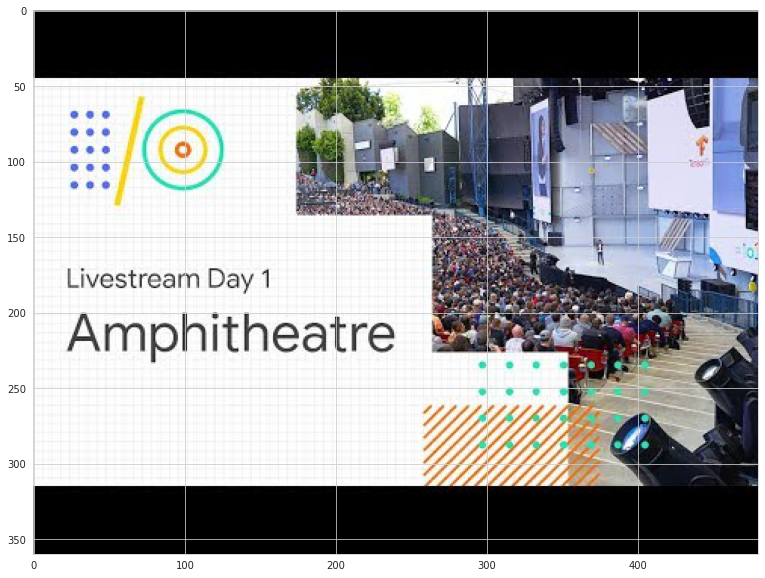

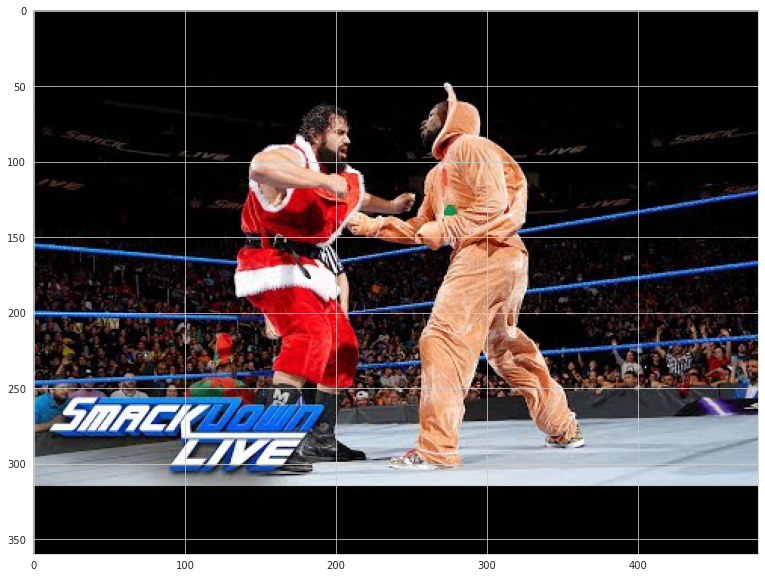

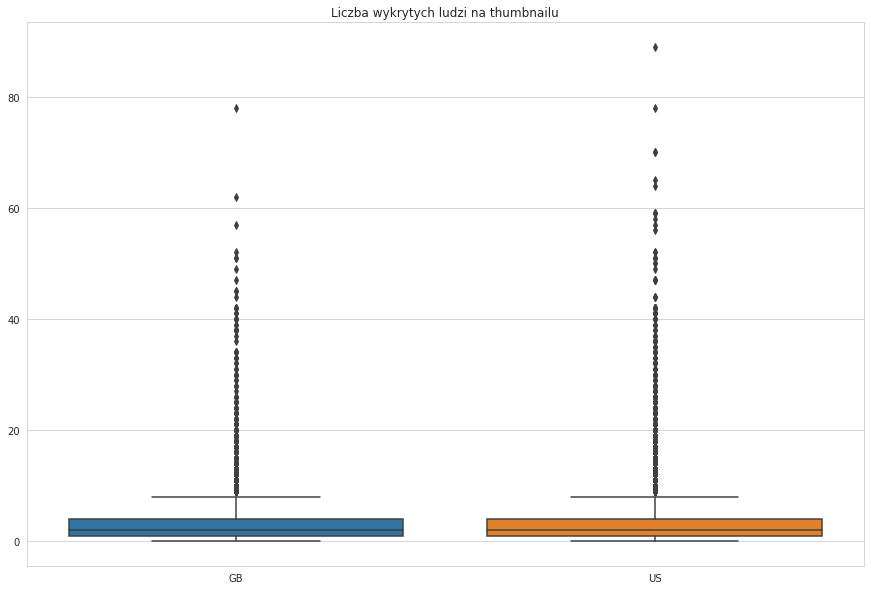

In [43]:
sns.set_style("whitegrid")
display("USA max:" + str(max(dfUS.people)) ,"USA mean:" + str(np.mean([dfUS.people])))
display("GB max:" + str(max(dfGb.people)) ,"GB mean:" + str(np.mean([dfGb.people])))


fig, ax = subplots(figsize=(15, 10))

print("ID filmu US z największą liczbą ludzi"+str(dfUS[dfUS.people == dfUS.people.max()]['id']))
img_path = PATH+"US"+"/GAkkKjds00o"+".png"
print("ID filmu GB z największą liczbą ludzi"+str(dfGb[dfGb.people == dfGb.people.max()]['id']))
img_path2 = PATH+"GB"+"/bwi9BNyKTcU"+".png"
img = image.load_img(img_path)
img2 = image.load_img(img_path2)
plt.imshow(img)
plt.show()
fig, ax = subplots(figsize=(15, 10))
plt.imshow(img2)
plt.show()
# display()

fig, ax = subplots(figsize=(15, 10))
data = [dfGb.people,dfUS.people]
ax = sns.boxplot( data=data)
ax.set_xticks([0,1])
ax.set_xticklabels(['GB','US'])
ax.set_title("Liczba wykrytych ludzi na thumbnailu")
plt.show()

# Podsumowanie wykrytych twarzy

'USA max:35.0'

'USA mean:1.35298173043778'

'GB max:15.0'

'GB mean:1.458493870402802'

ID filmu US z największą liczbą twarzy2771    TKhRjduXFEM
Name: id, dtype: object
ID filmu GB z największą liczbą twarzy785    XtqJd4-VX94
Name: id, dtype: object


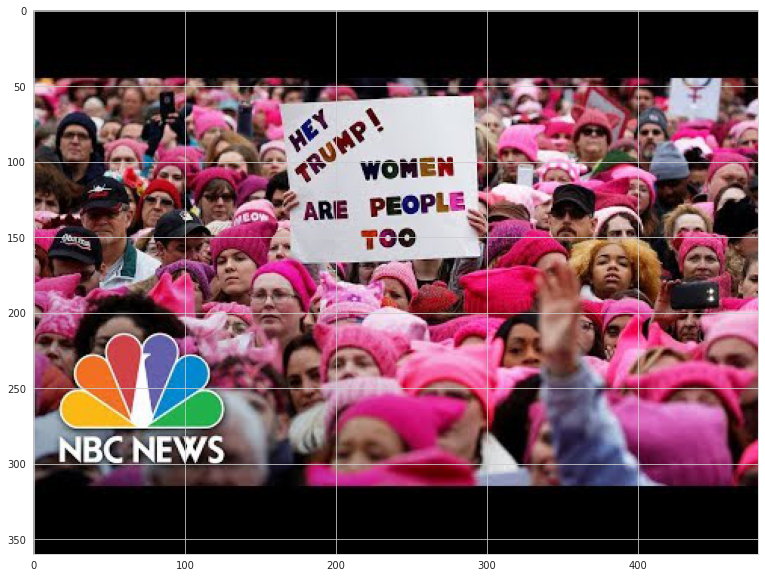

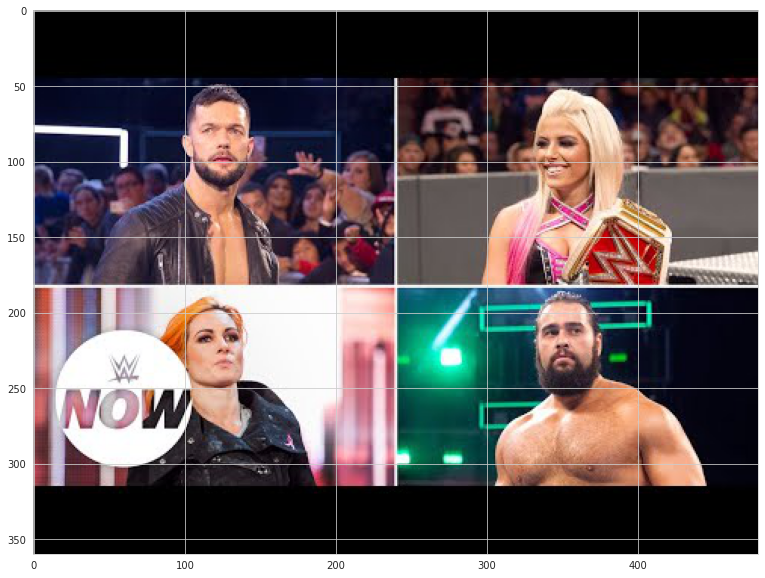

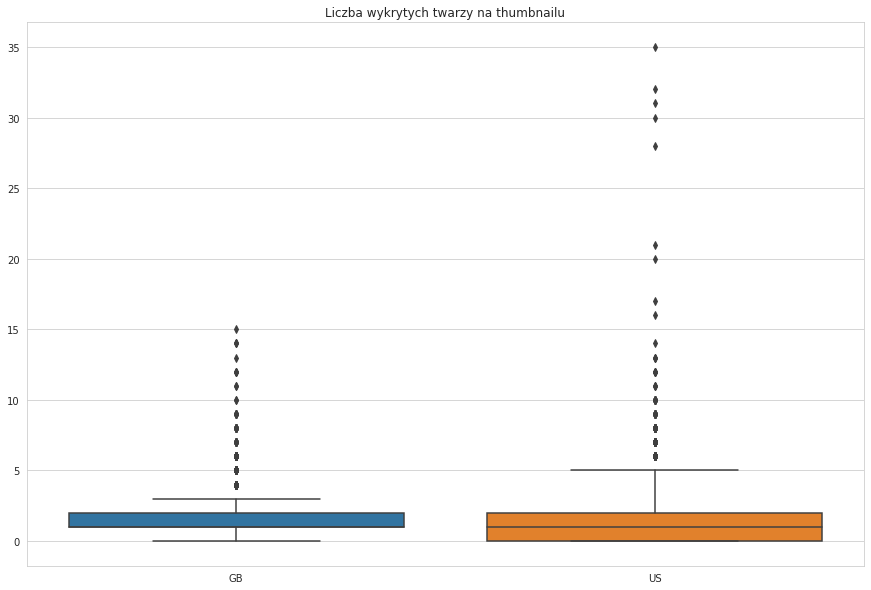

In [44]:
sns.set_style("whitegrid")
display("USA max:" + str(max(dfUS.faces)) ,"USA mean:" + str(np.mean([dfUS.faces])))
display("GB max:" + str(max(dfGb.faces)) ,"GB mean:" + str(np.mean([dfGb.faces])))


fig, ax = subplots(figsize=(15, 10))

print("ID filmu US z największą liczbą twarzy"+str(dfUS[dfUS.faces == dfUS.faces.max()]['id']))
img_path = PATH+"US"+"/TKhRjduXFEM"+".png"
print("ID filmu GB z największą liczbą twarzy"+str(dfGb[dfGb.faces == dfGb.faces.max()]['id']))
img_path2 = PATH+"GB"+"/XtqJd4-VX94"+".png"
img = image.load_img(img_path)
img2 = image.load_img(img_path2)
plt.imshow(img)
plt.show()
fig, ax = subplots(figsize=(15, 10))
plt.imshow(img2)
plt.show()
# display()
fig, ax = subplots(figsize=(15, 10))

data = [dfGb.faces,dfUS.faces]
ax = sns.boxplot( data=data)
ax.set_xticks([0,1])
ax.set_xticklabels(['GB','US'])
ax.set_title("Liczba wykrytych twarzy na thumbnailu")
# ax.set(yscale="log")
plt.show()

# Podsumowanie emocji dla GB

Sad         Fear        Angry        Happy      Neutral  \
count  2855.000000  2855.000000  2855.000000  2855.000000  2855.000000   
mean      0.347811     0.112434     0.241331     0.450088     0.298424   
std       0.684605     0.354621     0.557400     0.792094     0.584710   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     1.000000     0.000000   
max       6.000000     3.000000     6.000000     8.000000     5.000000   

          Surprise  
count  2855.000000  
mean      0.008406  
std       0.091316  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

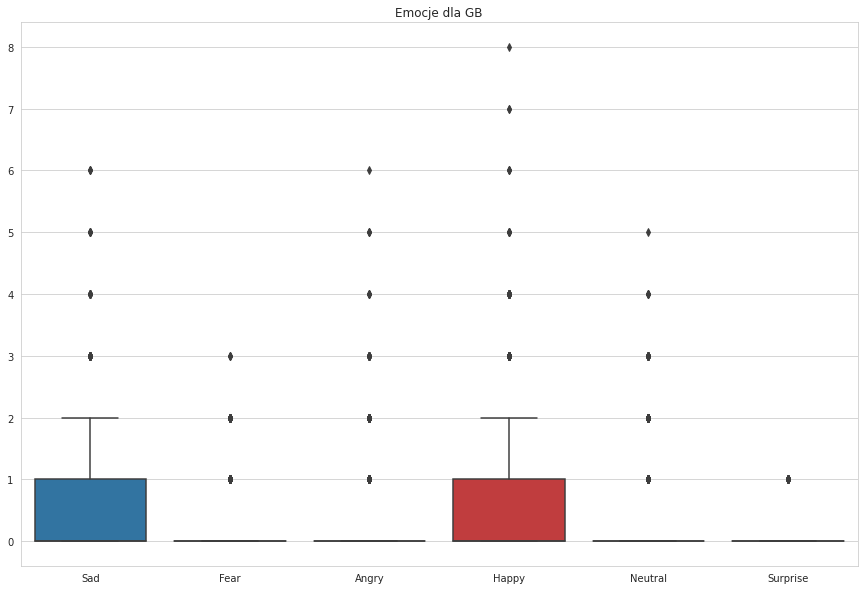

In [45]:
sns.set_style("whitegrid")
fig, ax = subplots(figsize=(15, 10))

display(dfGb.describe()[['Sad', 'Fear', 'Angry', 'Happy', 'Neutral','Surprise']])
data = dfGb[['Sad', 'Fear', 'Angry', 'Happy', 'Neutral','Surprise']]
ax = sns.boxplot( data=data)
ax.set_title("Emocje dla GB")
# ax.set(yscale="log")
plt.show()


# Podsumowanie emocji dla US

Sad         Fear        Angry        Happy      Neutral  \
count  5802.000000  5802.000000  5802.000000  5802.000000  5802.000000   
mean      0.301965     0.088418     0.216477     0.465874     0.265081   
std       0.717087     0.320973     0.553951     0.860734     0.575052   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     1.000000     0.000000   
max      15.000000     3.000000     8.000000    18.000000     6.000000   

          Surprise  
count  5802.000000  
mean      0.015167  
std       0.127745  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       2.000000

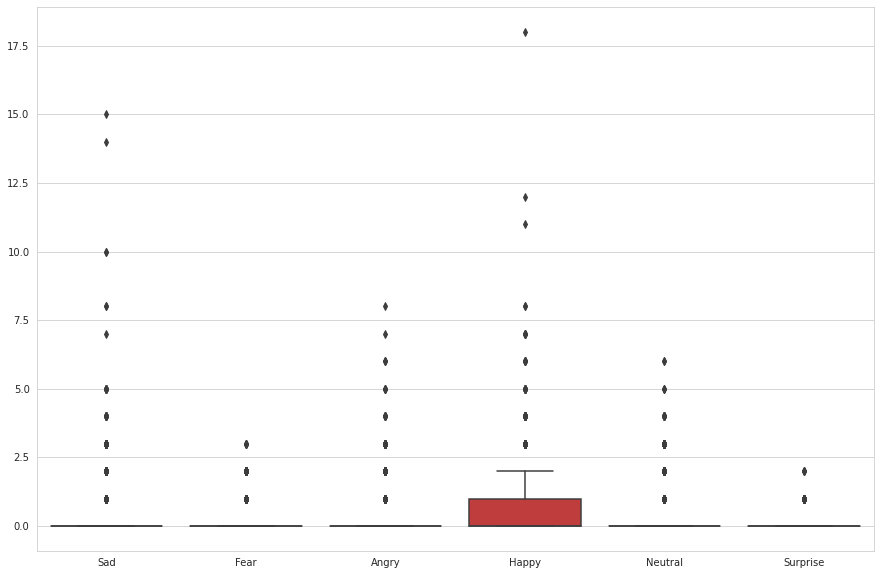

In [35]:
sns.set_style("whitegrid")
fig, ax = subplots(figsize=(15, 10))

display(dfUS.describe()[['Sad', 'Fear', 'Angry', 'Happy', 'Neutral','Surprise']])
data = dfUS[['Sad', 'Fear', 'Angry', 'Happy', 'Neutral','Surprise']]
ax = sns.boxplot( data=data)
# ax.set(yscale="log")
plt.show()


# Podsumowanie wykrytych obiektów (YOLO) dla US

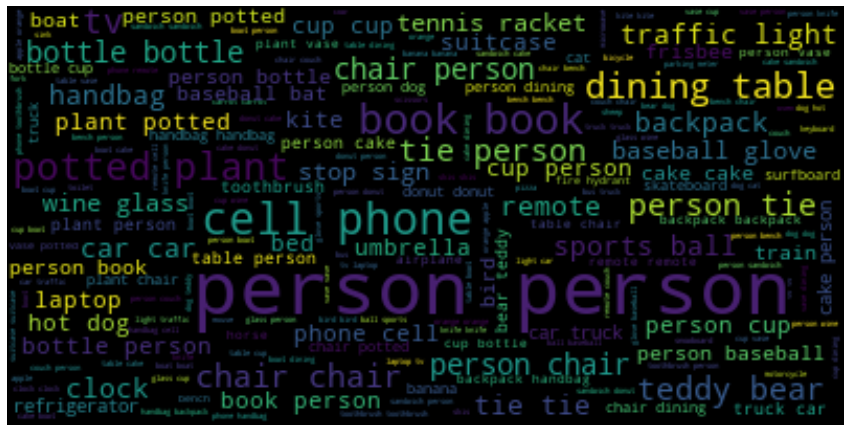

In [36]:
USwords = ""
for cat in dfUS.object_list:
    for c in cat:      
        if c != '':
            USwords = USwords+", ,"+ c
            
    
text = USwords

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
fig, ax = subplots(figsize=(15, 10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Podsumowanie wykrytych obiektów (YOLO) dla GB

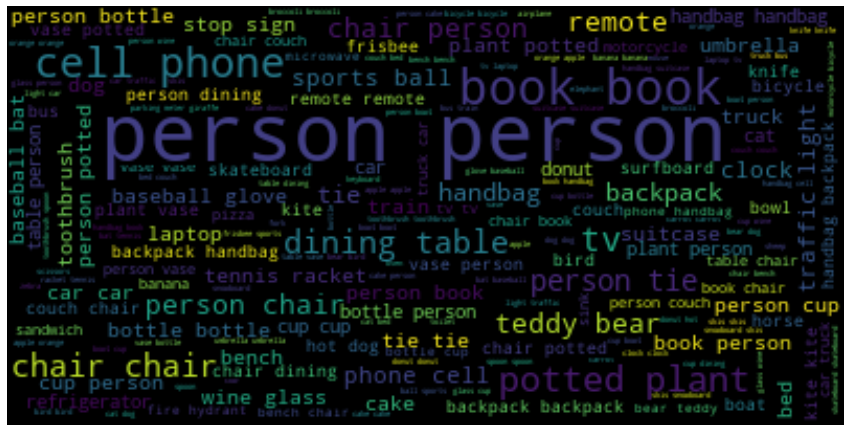

In [37]:
Gbwords = ""
for cat in dfGb.object_list:
    for c in cat:      
        if c != '':
            Gbwords = Gbwords+", "+ c
            
    
text = Gbwords

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
fig, ax = subplots(figsize=(15, 10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Podsumowanie wykrytych kategorii (resnet) dla US

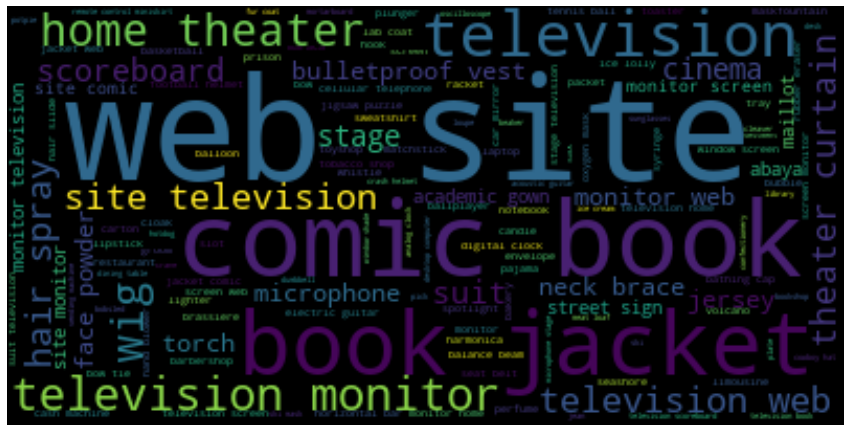

In [38]:
USwords = ""
for cat in dfUS.categories_list:
    for c in cat:      
        if c != '':
            USwords = USwords+", "+ c
            
    
text = USwords

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
fig, ax = subplots(figsize=(15, 10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Podsumowanie wykrytych kategorii (resnet) dla GB

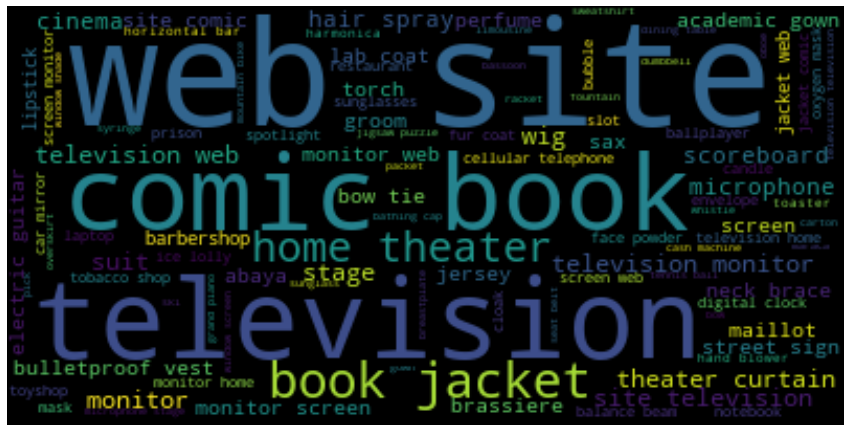

In [39]:
Gbwords = ""
for cat in dfGb.categories_list:
    for c in cat:      
        if c != '':
            Gbwords = Gbwords+", "+ c
            
    
text = Gbwords

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
fig, ax = subplots(figsize=(15, 10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()